In [1]:
from scapy.all import *

<img src="images/scapy_logo.png" width=200 style="float: left; padding-right: 10px"/>

# Scapy in 0x30 Minutes

@guedou

GreHack 2022

# Scapy?

- packets manipulation in Python
    - developed by Philippe Biondi, since 2003
    - maintained by Guillaume & Pierre, since 2012
    - native support on Linux, Mac OS X, *BSD, & Windows
        - on Windows, only `npcap.dll` is required


- get it at https://github.com/secdev/scapy
    - you can *star* the project !
- documentation at https://scapy.readthedocs.io

# Project Current Status

- moved to `github.com` on January 2016
    - used to be hosted on `bitbucket.org`
    
    
- **huge impact** on the project:    
    - ~300 different contributors
    - __continuous integration:__ Linux, macOS and  Windows
    - __code coverage:__ 85%

# Installing & Launching Scapy

It is as simple as cloning the git repository:

```
git clone --depth 1 https://github.com/secdev/scapy
cd scapy
sudo ./run_scapy
                     aSPY//YASa       
             apyyyyCY//////////YCa      |
            sY//////YSpcs  scpCY//Pp    | Welcome to Scapy
 ayp ayyyyyyySCP//Pp           syY//C   | Version 4ad7977
 AYAsAYYYYYYYY///Ps              cY//S  |
         pCCCCY//p          cSSps y//Y  | https://github.com/secdev/scapy
         SPPPP///a          pP///AC//Y  |
              A//A            cyP////C  | Have fun!
              p///Ac            sC///a  |
              P////YCpc           A//A  | To craft a packet, you have to be a
       scccccp///pSP///p          p//Y  | packet, and learn how to swim in
      sY/////////y  caa           S//P  | the wires and in the waves.
       cayCyayP//Ya              pY/Ya  |        -- Jean-Claude Van Damme
        sY/PsY////YCc          aC//Yp   |
         sc  sccaCY//PCypaapyCP//YSs  
                  spCPY//////YPSps    
                       ccaacs                                               
>>>
```

# Today's Tutorial?

I will escort you in the discovery of most Scapy features:


- packets manipulation
- interacting with the network
- visualization
- using Scapy as a Python module
- implementing a new protocol
- answering machines
- IPv6 reconnaissance
- X.509 certificates manipulation
- TLS tricks
- advanced features: automaton, pipes

## These slides are available at: https://guedou.github.io/

# Packets Manipulation

- packets are objects
- the `/` operator is used to stack packets

---

In [2]:
packet = IP() / TCP()
Ether() / packet

<Ether  type=IPv4 |<IP  frag=0 proto=tcp |<TCP  |>>>

- the `ls()` function list packets fields

---

```
>>> ls(IP, verbose=True)
version    : BitField (4 bits)                   = (4)
ihl        : BitField (4 bits)                   = (None)
tos        : XByteField                          = (0)
len        : ShortField                          = (None)
id         : ShortField                          = (1)
flags      : FlagsField (3 bits)                 = (0)
               MF, DF, evil
frag       : BitField (13 bits)                  = (0)
ttl        : ByteField                           = (64)
proto      : ByteEnumField                       = (0)
chksum     : XShortField                         = (None)
src        : SourceIPField (Emph)                = (None)
dst        : DestIPField (Emph)                  = (None)
options    : PacketListField                     = ([])
```

- Scapy selects the correct source IPv4 address, MAC addresses, ...

---

In [3]:
p = Ether() / IP(dst="www.secdev.org") / TCP(flags="F")
p.summary()

'Ether / IP / TCP 192.168.46.10:ftp_data > www.secdev.org:http F'

- all fields can be easily accessed

---

In [4]:
print(p.dst)      # first layer with a dst field, i.e. Ether
print(p[IP].src)  # explicit access to the IP layer src field

# sprintf() supports Scapy own formats strings
print(p.sprintf("%Ether.src% > %Ether.dst%\n%IP.src% > %IP.dst%"))

ac:16:2d:9c:3c:ad
192.168.46.10
b8:ca:3a:72:b0:8b > ac:16:2d:9c:3c:ad
192.168.46.10 > www.secdev.org


- a field can store many values

---

In [5]:
[p for p in IP(ttl=(1,5)) / ICMP()]  # a sequence of values from 1 to 5

[<IP  frag=0 ttl=1 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=2 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=3 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=4 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=5 proto=icmp |<ICMP  |>>]

In [6]:
[p for p in IP() / TCP(dport=[22, 80, 443])]  # specific values

[<IP  frag=0 proto=tcp |<TCP  dport=ssh |>>,
 <IP  frag=0 proto=tcp |<TCP  dport=http |>>,
 <IP  frag=0 proto=tcp |<TCP  dport=https |>>]

# Interacting with the network

- the `sr1()` function sends a packet and returns a reply
- Scapy can match queries and answers
    
---

In [7]:
p = sr1(IP(dst="8.8.8.8") / UDP() / DNS())
p[DNS].an

Begin emission:
Finished to send 1 packets.

Received 9 packets, got 1 answers, remaining 0 packets


<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=15631 rdata='93.184.216.34' |>

- the `srp()` function sends a list of frames and returns two variables:
    1. `r` a list of queries and matched answers
    2. `u` a list of unanswered packets

---

In [8]:
r, u = srp(Ether() / IP(dst="8.8.8.8", ttl=(5, 10)) / UDP() / DNS())
r, u

Begin emission:
Finished to send 6 packets.

Received 6 packets, got 6 answers, remaining 0 packets


(<Results: TCP:0 UDP:1 ICMP:5 Other:0>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:0>)

In [9]:
# Access the first tuple
print(r[0][0].summary())  # sent packet
print(r[0][1].summary())  # received packet

# Scapy received an ICMP time-exceeded
r[0][1][ICMP]

Ether / IP / UDP / DNS Qry "www.example.com" 
Ether / IP / ICMP 193.252.98.177 > 192.168.46.10 time-exceeded ttl-zero-during-transit / IPerror / UDPerror


<ICMP  type=time-exceeded code=ttl-zero-during-transit chksum=0x3e59 reserved=0 length=0 unused=None |<IPerror  version=4 ihl=5 tos=0x0 len=61 id=1 flags= frag=0 ttl=1 proto=udp chksum=0xbaed src=192.168.46.10 dst=8.8.8.8 options=[] |<UDPerror  sport=domain dport=domain len=41 chksum=0xb613 |>>>

- a list of packets can be written to and read from a `PCAP` file

---

In [10]:
wrpcap("scapy.pcap", r)

pcap_p = rdpcap("scapy.pcap")
pcap_p[0]

<Ether  dst=ac:16:2d:9c:3c:ad src=b8:ca:3a:72:b0:8b type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=61 id=1 flags= frag=0 ttl=5 proto=udp chksum=0xb6ed src=192.168.46.10 dst=8.8.8.8 options=[] |<UDP  sport=domain dport=domain len=41 chksum=0xb613 |<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

- the `command()` method gives the string that will build the *same* object

---

In [11]:
pcap_p[0].command()

"Ether(src='b8:ca:3a:72:b0:8b', dst='ac:16:2d:9c:3c:ad', type=2048)/IP(frag=0, src='192.168.46.10', proto=17, tos=0, dst='8.8.8.8', chksum=46829, len=61, options=[], version=4, flags=0, ihl=5, ttl=5, id=1)/UDP(dport=53, sport=53, len=41, chksum=46611)/DNS(aa=0, qr=0, an=None, ad=0, nscount=0, qdcount=1, ns=None, tc=0, rd=1, arcount=0, length=None, ar=None, opcode=0, ra=0, cd=0, z=0, rcode=0, id=0, ancount=0, qd=DNSQR(qclass=1, qtype=1, qname='www.example.com.'))"

- the `sniff()` function captures packets 

---

In [12]:
s = sniff(count=2)
s

<Sniffed: TCP:2 UDP:0 ICMP:0 Other:0>

In [13]:
sniff(count=2, prn=lambda p: p.summary())

Ether / IPv6 / TCP ::1:8888 > ::1:44278 PA / Raw
Ether / IPv6 / TCP ::1:8888 > ::1:44278 PA / Raw


<Sniffed: TCP:2 UDP:0 ICMP:0 Other:0>

- the `lsc()` function lists available commands 

---

```
>>> lsc()
IPID_count          : Identify IP id values classes in a list of packets
arpcachepoison      : Poison target's cache with (your MAC,victim's IP) couple
arping              : Send ARP who-has requests to determine which hosts are up
bind_layers         : Bind 2 layers on some specific fields' values
bridge_and_sniff    : Forward traffic between interfaces if1 and if2, sniff and return the
chexdump            :  Build a per byte hexadecimal representation
computeNIGroupAddr  : Compute the NI group Address. Can take a FQDN as input parameter
corrupt_bits        : Flip a given percentage or number of bits from a string
corrupt_bytes       : Corrupt a given percentage or number of bytes from a string
defrag              : defrag(plist) -> ([not fragmented], [defragmented],
defragment          : defrag(plist) -> plist defragmented as much as possible 
dhcp_request        : --
[..]
```

In [14]:
# Send ARP who-has requests to determine which hosts are up
arping("192.168.46.0/24")

Begin emission:
Finished to send 256 packets.

Received 2 packets, got 2 answers, remaining 254 packets
  b8:6b:23:cf:12:83 192.168.46.22
  ac:16:2d:9c:3c:ad 192.168.46.254


(<ARPing: TCP:0 UDP:0 ICMP:0 Other:2>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:254>)

- the `help()` function describes commands behaviors and arguments

---

```
>>> help(traceroute)
Help on function traceroute in module scapy.layers.inet:

traceroute(target, dport=80, minttl=1, maxttl=30, sport=<RandShort>, l4=None, filter=None, timeout=2, verbose=None, **kargs)
    Instant TCP traceroute
    traceroute(target, [maxttl=30,] [dport=80,] [sport=80,] [verbose=conf.verb]) -> None
```

# Visualization

- with `srloop()`, send 100 packets to 8.8.8.8 and 8.8.4.4
- the `multiplot()` method can be used to display IP ID values

---

In [15]:
ans, unans = srloop(IP(dst=["8.8.8.8", "8.8.4.4"]) / ICMP(), inter=.1, timeout=.1, count=100, verbose=False)

[[<matplotlib.lines.Line2D at 0x7fb432f4c5d0>],

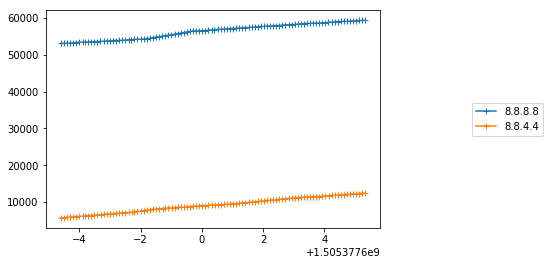

In [16]:
%matplotlib inline
ans.multiplot(lambda (x, y): (y[IP].src, (y.time, y[IP].id)), plot_xy=True)

- the `str()` function builds a packet, as sent on the network

In [17]:
pkt = IP() / UDP() / DNS(qd=DNSQR())
repr(str(pkt))

"'E\\x00\\x00=\\x00\\x01\\x00\\x00@\\x11|\\xad\\x7f\\x00\\x00\\x01\\x7f\\x00\\x00\\x01\\x005\\x005\\x00)\\xb6\\xd3\\x00\\x00\\x01\\x00\\x00\\x01\\x00\\x00\\x00\\x00\\x00\\x00\\x03www\\x07example\\x03com\\x00\\x00\\x01\\x00\\x01'"

This representation being complicated, Scapy can:
   -  do a `hexdump` of the content

In [18]:
hexdump(pkt)

0000  4500003D0001000040117CAD7F000001 E..=....@.|.....
0010  7F000001003500350029B6D300000100 .....5.5.)......
0020  00010000000000000377777707657861 .........www.exa
0030  6D706C6503636F6D0000010001       mple.com.....


  - dump fields content layer by layer

In [19]:
pkt.show()

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = udp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ UDP ]### 
     sport     = domain
     dport     = domain
     len       = None
     chksum    = None
###[ DNS ]### 
        id        = 0
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'www.example.com'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        ar        = None



  - display a pretty representation

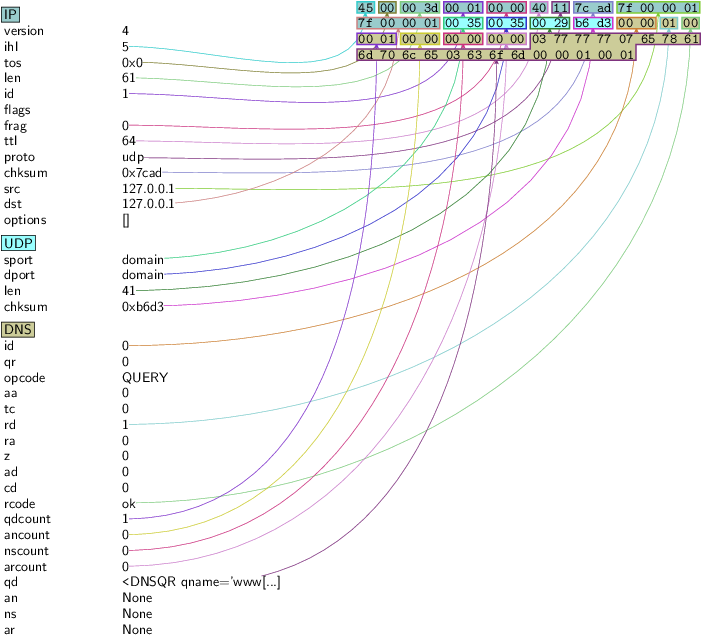

In [20]:
pkt.canvas_dump()

The `traceroute()` functions calls `sr(IP(ttl=(1,15))` and create the object `TracerouteResult`

---

In [21]:
ans, unans = traceroute('www.secdev.org', maxttl=15)

Begin emission:
Finished to send 15 packets.

Received 15 packets, got 15 answers, remaining 0 packets
   217.25.178.5:tcp80 
1  192.168.46.254  11 
2  172.28.0.1      11 
3  80.10.115.251   11 
4  10.123.205.82   11 
5  193.252.98.177  11 
6  81.253.184.182  11 
7  130.117.15.93   11 
8  154.54.38.65    11 
9  154.25.5.2      11 
10 149.6.166.166   11 
11 154.25.4.254    11 
12 217.25.179.78   11 
13 217.25.178.5    SA 
14 217.25.178.5    SA 
15 217.25.178.5    SA 


Different methods can be used to display the results, like `world_trace()` that uses the GeoIP module from [MaxMind](https://www.maxmind.com/)

---

[[<matplotlib.lines.Line2D at 0x7fb432ee41d0>]]

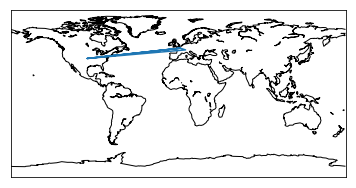

In [22]:
ans.world_trace()

The `make_table()` method provides a compact results representation, useful for a basic *port scanner*

---

In [23]:
targets = ["scanme.nmap.org", "nmap.org"]

ans = sr(IP(dst=targets) / TCP(dport=[22, 80, 443, 31337]), timeout=3, verbose=False)[0]

ans.extend(sr(IP(dst=targets) / UDP() / DNS(), timeout=3, verbose=False)[0])

ans.make_table(lambda (x, y): (x[IP].dst,
                               x.sprintf('%IP.proto%/{TCP:%r,TCP.dport%}{UDP:%r,UDP.dport%}'),
                               y.sprintf('{TCP:%TCP.flags%}{ICMP:%ICMP.type%}')))

          45.33.32.156 45.33.49.119 
tcp/22    SA           SA           
tcp/31337 SA           RA           
tcp/443   RA           SA           
tcp/80    SA           SA           
udp/53    dest-unreach -            


## Scapy as a Python module

Scapy can be used to build your own tools like `ping6.py`:

---

In [ ]:
from scapy.all import *
import argparse

parser = argparse.ArgumentParser(description="A simple ping6")
parser.add_argument("ipv6_address", help="An IPv6 address")
args = parser.parse_args()

print sr1(IPv6(dst=args.ipv6_address) / ICMPv6EchoRequest(), verbose=0).summary()

```shell
sudo python ping6.py www.kame.net
IPv6 / ICMPv6 Echo Reply (id: 0x0 seq: 0x0)
```

# Implementing a new protocol

To add new protocols, create an object:
- that inherits from `Packet`
- defines fields in the `fields_desc` variable

---

In [24]:
class DNSTCP(Packet):
    name = "DNS over TCP"
    
    fields_desc = [ FieldLenField("len", None, fmt="!H", length_of="dns"),
                    PacketLenField("dns", 0, DNS, length_from=lambda p: p.len)]
    
    # This method tells Scapy to decode the payload with DNSTCP
    def guess_payload_class(self, payload):
        return DNSTCP

This new protocol can be directly used to build and parse a packet

---

In [25]:
DNSTCP(raw(DNSTCP(dns=DNS())))

<DNSTCP  len=12 dns=<DNS  id=0 qr=0 opcode=QUERY aa=0 tc=0 rd=1 ra=0 z=0 ad=0 cd=0 rcode=ok qdcount=0 ancount=0 nscount=0 arcount=0 |> |>

The `StreamSocket` object allows Scapy to use a TCP socket

---

In [26]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_STREAM)  # create a TCP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/TCP

# Create a StreamSocket and define the default class
ssck = StreamSocket(sck)
ssck.basecls = DNSTCP

# Send the DNS query
ssck.sr1(DNSTCP(dns=DNS(qd=DNSQR(qname="www.example.com"))))

Begin emission:
Finished to send 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<DNSTCP  len=49 dns=<DNS  id=0 qr=1 opcode=QUERY aa=0 tc=0 rd=1 ra=1 z=0 ad=0 cd=0 rcode=ok qdcount=1 ancount=1 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=66630 rdata='93.184.216.34' |> ns=None ar=None |> |>

## Answering Machines

Scapy can wait for a query, then send an answer with the `AnsweringMachine` object.

Two methods are mandatory:
1. `is_request()`: returns `True` if the packet is the expected query
2. `make_reply()`: returns the packet that will be sent by Scapy


Note: in the following example, the Wi-Fi interface must be put in *monitor* mode

In [ ]:
# Specify the Wi-Fi interface
conf.iface = "mon0"

# Create the Answering Machine
class ProbeRequest_am(AnsweringMachine):
  function_name = "pram"

  mac = "00:11:22:33:44:55"

  def is_request(self, pkt):
    return Dot11ProbeReq in pkt

  def make_reply(self, req):

    rep = RadioTap()
    # Note: depending on your Wi-Fi card, you might need something else than RadioTap()
    rep /= Dot11(addr1=req.addr2, addr2=self.mac, addr3=self.mac, ID=RandShort(), SC=RandShort())
    rep /= Dot11ProbeResp(cap="ESS", timestamp=time.time())
    rep /= Dot11Elt(ID="SSID",info="Scapy !")
    rep /= Dot11Elt(ID="Rates",info='\x82\x84\x0b\x16\x96')
    rep /= Dot11Elt(ID="DSset",info=chr(10))

    return rep

# Start the answering machine
#ProbeRequest_am()()  # uncomment to test

![](images/scapy_am.png)

# IPv6 Reconnaissance

- discover the link IPv6 router using the Router Solicitation message

---

In [28]:
sr1(IPv6() / ICMPv6ND_RS())

Begin emission:
Finished to send 1 packets.

Received 98 packets, got 0 answers, remaining 1 packets
<IPv6  version=6L tc=192L fl=0L plen=104 nh=ICMPv6 hlim=255 src=fe80::ba26:6cff:fe5f:4eee dst=ff02::1 |<ICMPv6ND_RA  type=Router Advertisement code=0 cksum=0x4c25 chlim=64 M=0L O=1L H=0L prf=High P=0L res=0L routerlifetime=180 reachabletime=0 retranstimer=0 |<ICMPv6NDOptPrefixInfo  type=3 len=4 prefixlen=64 L=1L A=1L R=0L res1=0L validlifetime=0x384 preferredlifetime=0x12c res2=0x0 prefix=2a01:cb08:229:3700:: |<ICMPv6NDOptRDNSS  type=25 len=3 res=0 lifetime=60 dns=[ fe80::ba26:6cff:fe5f:4eee ] |<ICMPv6NDOptDNSSL  type=31 len=2 res=0 lifetime=60 searchlist=['home.'] |<ICMPv6NDOptMTU  type=5 len=1 res=0x0 mtu=1500 |<ICMPv6NDOptSrcLLAddr  type=1 len=1 lladdr=b8:26:6c:5f:4e:ee |>>>>>>>


- probe local nodes and list manufacturers

---

In [29]:
a,u = sr(IPv6(dst="ff02::1") / ICMPv6EchoRequest(), multi=1, timeout=1)
a.make_table(lambda t: (t[0][IPv6].dst, t[1][IPv6].src, in6_addrtovendor(t[1][IPv6].src)))

Begin emission:
Finished to send 1 packets.

Received 20 packets, got 0 answers, remaining 1 packets
 
                          ff02::1
fe80::5664:d9ff:fe79:4e00 54:64:d9:79:4e:00
fe80::a2f3:c1ff:fec4:5b50 a0:f3:c1:c4:5b:50
fe80::ba26:6cff:fe5f:4eee b8:26:6c:5f:4e:ee

# X.509 Certificates Manipulation

- Scapy can easily parse certificates, and display their contents

---

In [27]:
load_layer("tls")
cert_github = Cert(pem2der(open("files/github.com.pem").read()))  # assuming you d/l the certificate
cert_github

[X.509 Cert. Subject:/C=US/ST=California/L=San Francisco/O=GitHub, Inc./CN=github.com/businessCategory=Private Organization/jurisdictionOfIncorporationCountryName=US/jurisdictionOfIncorporationStateOrProvinceName=Delaware/postalCode=94107/serialNumber=5157550/streetAddress=88 Colin P Kelly, Jr Street, Issuer:/C=US/O=DigiCert Inc/OU=www.digicert.com/CN=DigiCert SHA2 Extended Validation Server CA]

- several useful methods help exploring them

---

In [30]:
print(cert_github.isSelfSigned())  # check if it is self signed
print(cert_github.subject)  # display the subject
print(cert_github.remainingDays()) # compute the number of days until expiration

False
{'organizationName': 'GitHub, Inc.', 'localityName': 'San Francisco', 'businessCategory': 'Private Organization', 'jurisdictionOfIncorporationStateOrProvinceName': 'Delaware', 'serialNumber': '5157550', 'commonName': 'github.com', 'stateOrProvinceName': 'California', 'countryName': 'US', 'streetAddress': '88 Colin P Kelly, Jr Street', 'jurisdictionOfIncorporationCountryName': 'US', 'postalCode': '94107'}
245.063206019


- moreover, some cryptographic tricks are also included, like verifying signatures:

---

In [31]:
# Verify issuers signatures
cert_digicert = Cert(pem2der(open("files/digicert_sha2.pem").read())) # assuming you d/l the certificate        
print(cert_github.isIssuerCert(cert_digicert))  # check the signature

True


- or, change the certificate signature:

---

In [32]:
cert_github.tbsCertificate.serialNumber.val = 0x42  # Change a value

private_key = PrivKeyRSA("files/private_key.pem")  # Load a private key
new_cert_github = private_key.resignCert(cert_github)  # Do a new signature

print(hex(new_cert_github.tbsCertificate.serialNumber.val))  # Print the value
print(private_key.verifyCert(new_cert_github))  # Verify the signature

0x42
True


# TLS tricks

- sniff TLS traffic

---

In [34]:
load_layer("tls")
s = sniff(filter="port 443", count=10)  # sniff packets on port 443
ch_list = [p for p in s if TLSClientHello in p]  # filter Client Hello messages
ch_list[0][TLSClientHello].show()  # display the first message

###[ TLS Handshake - Client Hello ]### 
  msgtype   = client_hello
  msglen    = 508
  version   = TLS 1.2
  gmt_unix_time= Mon, 12 Sep 2033 09:17:31 +0000 (2010129451)
  random_bytes= 10acad3c14813c361b0a5a37a26b49c03731452d4139c9907f2c2f70
  sidlen    = 32
  sid       = '\x00;\xd3\x8fQy?\xbe\xc9\x85P\xa2\xb6\x8f\xa3FF\x9f\x97I\x06\x94)\x06\xc0\x9b\xea\x1b\xa2$\x0f\x08'
  cipherslen= 28
  ciphers   = [0x7a7a, TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256, TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256, TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384, TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384, TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256, TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256, TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA, TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA, TLS_RSA_WITH_AES_128_GCM_SHA256, TLS_RSA_WITH_AES_256_GCM_SHA384, TLS_RSA_WITH_AES_128_CBC_SHA, TLS_RSA_WITH_AES_256_CBC_SHA, TLS_RSA_WITH_3DES_EDE_CBC_SHA]
  complen   = 1
  comp      = null
  extlen    = 407
  \ext       \
   |###[ TLS Extension - Scapy Unknow

## Advanced Features

- **automaton**: ease the creation of state machines with decorators


- **pipes** can be used for advanced manipulations: forwarding between interfaces, on the fly modifications, ...


- the **nfqueue** Python module could be used to perform simple MitM

# Questions?
# Issues?
# Pull Requests?
# Beers?